LIBRARY IMPORTS AT THE BEGINNING . 

In [262]:

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import os
from plotly.subplots import make_subplots
from termcolor import colored
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
import gc
import itertools
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate 


SOME USEFUL STYLES AND WARNINGS 

In [263]:
pio.templates.default = "simple_white"
antq_blue = "#336699"
antq_purple = "#ac39ac"
antq_red = "#e63900"
antq_orange = "#ff8c1a"
faded_grey = "#e6e6e6"
light_grey = "#d9d9d9"
heading_font = "Brush Script MT, Brush Script Std, cursive"
normal_font = "times new roman"
palette = px.colors.qualitative.Set2
palette_r = px.colors.qualitative.Set2_r
set1 = px.colors.qualitative.Set1
set3 = px.colors.qualitative.Set3
warnings.filterwarnings('ignore')

DATA SUMMARY - This is some of the data which will be used in this project .
dataset -> This is the main dataset which contains the information about the anime(movies and TV) .
Ratings_Dataset -> This contains the dataset which contains the information of rating of show given by each user .

In [264]:
dataset = pd.read_csv(r"Data\anime.csv")
dataset.head()
# this is returning me the data which is present in the dataset .       

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [265]:
Ratings_Dataset = pd.read_csv(r"Data\rating.csv")
Ratings_Dataset.head() 

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [266]:
dataset[dataset.name == 'Pokemon'] # this is how we can see an anime based on the name

,anime_id,name,genre,type,episodes,rating,members
1834,527,Pokemon,"Action, Adventure, Comedy, Fantasy, Kids",TV,276,7.43,229157


In [267]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


The Number of Enteries in the Datasets of Anime and Ratings are as follows: 

In [268]:
print(f'anime shape: {dataset.shape}\nrating shape: {Ratings_Dataset.shape}')

anime shape: (12294, 7)
rating shape: (7813737, 3)


Check the Missing Values

In [269]:
Ratings_Dataset.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [270]:
dataset.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Now that we get the missing rows in both the datasets we can remove them as they are not useful for us .

REMOVING MISSING ROWS

In [271]:
dataset.dropna(axis=0 , inplace=True)
dataset.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [272]:
dataset.describe()

,anime_id,rating,members
count,12017.000000,12017.000000,1.201700e+04
mean,13638.001165,6.478264,1.834888e+04
std,11231.076675,1.023857,5.537250e+04
min,1.000000,1.670000,1.200000e+01
25%,3391.000000,5.890000,2.250000e+02
50%,9959.000000,6.570000,1.552000e+03
75%,23729.000000,7.180000,9.588000e+03
max,34519.000000,10.000000,1.013917e+06


Now let see the episodes which are there in the various animes

In [273]:
dataset.episodes.value_counts()

episodes
1      5571
2      1075
12      810
13      571
26      514
       ... 
358       1
366       1
201       1
172       1
125       1
Name: count, Length: 187, dtype: int64

Now we remove the duplicates from the DATASET after checking for them .

In [274]:
number_of_duplicated_anime = dataset[dataset.duplicated()].shape[0] 
print(f"the number of duplicated anime are:{number_of_duplicated_anime}")

the number of duplicated anime are:0


In [275]:
number_of_duplicated_ratings = Ratings_Dataset[Ratings_Dataset.duplicated()].shape[0] 
print(f"the number of duplicated ratings are:{number_of_duplicated_ratings}")

the number of duplicated ratings are:1


In [276]:
Ratings_Dataset.drop_duplicates(keep='first', inplace=True)
number_of_duplicated_ratings = Ratings_Dataset[Ratings_Dataset.duplicated()].shape[0] 
print(f"the number of duplicated ratings are:{number_of_duplicated_ratings}")

the number of duplicated ratings are:0


CREATING THE DATABASE 

We can now create the merged dataset from these two csv files as follows :

In [277]:
final_dataset = pd.merge(dataset , Ratings_Dataset , on ="anime_id")
final_dataset.tail()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
7813605,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,39532,-1
7813606,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,48766,-1
7813607,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,60365,4
7813608,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142,27364,-1
7813609,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142,48766,-1


In [278]:
final_dataset.describe()

,anime_id,rating_x,members,user_id,rating_y
count,7.813610e+06,7.813610e+06,7.813610e+06,7.813610e+06,7.813610e+06
mean,8.908728e+03,7.653158e+00,1.786233e+05,3.672799e+04,6.144075e+00
std,8.883598e+03,6.729753e-01,1.881764e+05,2.099793e+04,3.727792e+00
min,1.000000e+00,1.670000e+00,2.900000e+01,1.000000e+00,-1.000000e+00
25%,1.240000e+03,7.270000e+00,4.403000e+04,1.897400e+04,6.000000e+00
50%,6.213000e+03,7.680000e+00,1.104700e+05,3.679100e+04,7.000000e+00
75%,1.409300e+04,8.130000e+00,2.442680e+05,5.475800e+04,9.000000e+00
max,3.451900e+04,9.500000e+00,1.013917e+06,7.351600e+04,1.000000e+01


NOW LETS START WITH THE DIFFERENT TYPES OF RECOMMENDATION SYSTEMS .

1. Popular based recommendation 

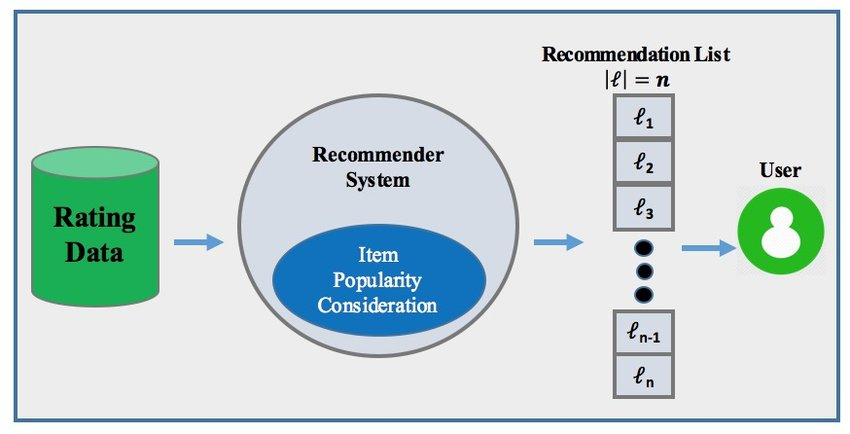

<font color = 'red'><u>Introduction</u></font>

For any machine learning problems, we need a baseline model or method to use as a reference whether our approach is good or not.Our machine learning prediction or sophsticated analysis should, at least, beat those baseline performance.For recommendation systems, a simple baseline could be recommending popular items to users. This baseline assumes that if an item is popular among many users, it's likely to be a good recommendation for new users as well. Thus , this is the simplest model for any recommendation system . 

<font color = 'red'><b>To define the popularity of the item</b></font>

Regarding the IMDB system , we use a metrics called the weighted rating system which is used to score the rating of each movie . 

The formulae for the same is :

Wr = (v / (v+m)) * R + (m / (v+m)) * C 

here , R = average rating of the show/movie 

v = total number of people's votes for the movie  

m = minimum votes required to be listed in the top 250(This number may vary as its defined by > 80 percentile of total votes) 

C = the average rating across the whole dataset   

<font color = 'red'><b>Disadvantages(Drawbacks)</b></font>

This method is not personalised for each user , each user gets the exact same result . 

<font color = 'red'><b>Use case </b></font>

For new users , if we dont know there liked shows and their favourite genres , we can provide them list based on ranking based on weighted_rating as this is the simplest model . 

This is how the streaming platforms work when we search by "popular" on them . 

<font color = 'red'><b>Refrence</b></font>

https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV?ref_=helpms_helpart_inline#

In [279]:
# Lets first do the pre-processing of the Ratings_Dataset to be used in this . 
def show_full_data(dataset, Ratings_Dataset):
  full_data_set = Ratings_Dataset.merge(dataset[['anime_id' , 'name']] , on = ['anime_id'] , how='left') # same as left joint 

  full_data_set = full_data_set.loc[:, ['anime_id' , 'name' , 'count_of_votes' , 'average_rating' , 'weighted_rating']]

  return full_data_set
  

def pre_prepocessing(Ratings_Dataset):
  Ratings_Dataset = Ratings_Dataset[Ratings_Dataset['rating'] != -1]
  Ratings_Dataset = Ratings_Dataset.groupby('anime_id' , as_index=False).agg({'user_id' : 'count' , 'rating' :'mean'})
  Ratings_Dataset.columns = ['anime_id','count_of_votes' ,'average_rating'] 

  return Ratings_Dataset

def weighted_rating(R,v,m,C):
  return (v/(v+m)) * R + (m/(v+m)) * C 

def find_popularity_based_ranking_score(dataset , Ratings_Dataset):
  Ratings_Dataset = pre_prepocessing(Ratings_Dataset)
  C = np.mean(Ratings_Dataset['average_rating'])
  m = np.percentile(Ratings_Dataset['count_of_votes'] , 80) 
  Ratings_Dataset = Ratings_Dataset[Ratings_Dataset['count_of_votes'] >= m]
  R = Ratings_Dataset['average_rating']
  v = Ratings_Dataset['count_of_votes']
  Ratings_Dataset['weighted_rating'] = weighted_rating(R,v,m,C)  # now this column will help to identify the weighted rating

  Ratings_Dataset = show_full_data(dataset , Ratings_Dataset)
  
  return Ratings_Dataset 



  

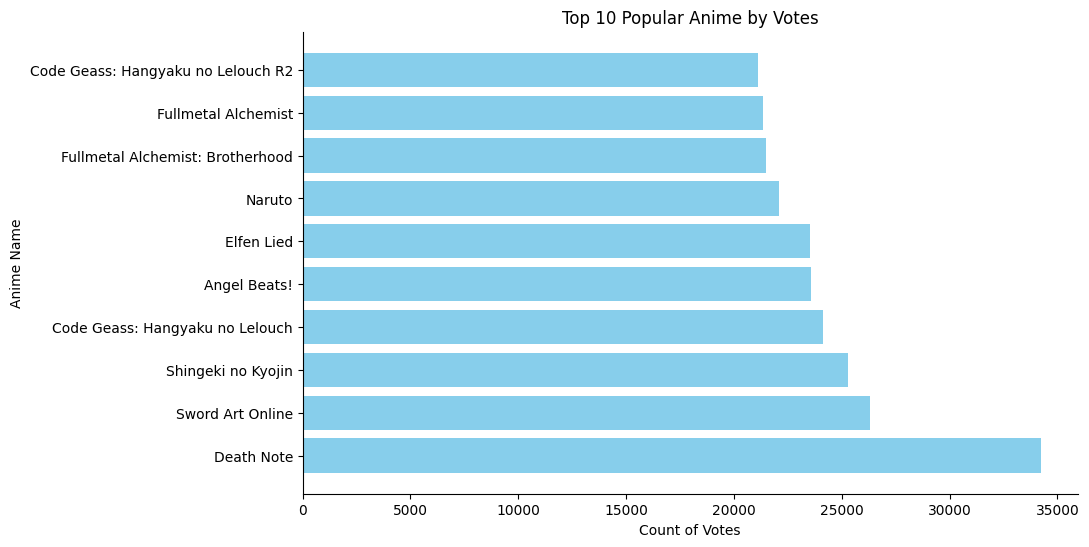

In [280]:
# this is the plot based on the number of votes count 

top_popular_anime = find_popularity_based_ranking_score(dataset , Ratings_Dataset)

top_popular_sorted = top_popular_anime.sort_values('count_of_votes', ascending=False).head(10)


names = top_popular_sorted['name']
votes = top_popular_sorted['count_of_votes']

plt.figure(figsize=(10, 6))
plt.barh(names, votes, color='skyblue')  
plt.xlabel('Count of Votes')
plt.ylabel('Anime Name')
plt.title('Top 10 Popular Anime by Votes')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

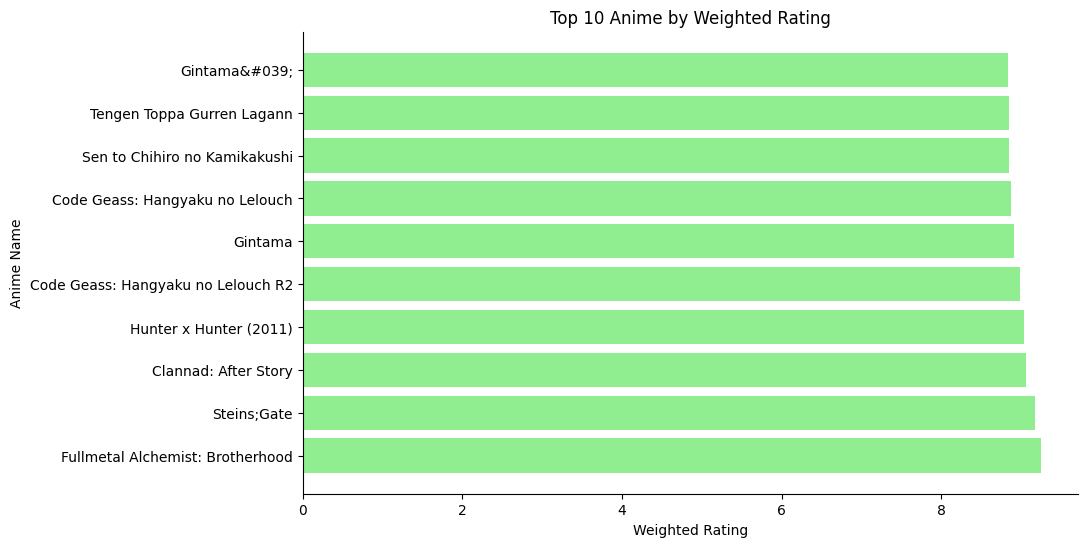

In [281]:

popular_sorted = top_popular_anime.sort_values('weighted_rating', ascending=False).head(10)


names = popular_sorted['name']
ratings = popular_sorted['weighted_rating']


plt.figure(figsize=(10, 6))
plt.barh(names, ratings, color='lightgreen')  
plt.xlabel('Weighted Rating')
plt.ylabel('Anime Name')
plt.title('Top 10 Anime by Weighted Rating')


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Now , we will evaluate this on dataset , we are making train and the test set from the Rating_dataset , where points are choosen at random .

<font color = 'red'><b>EVALUATION</b></font>


In [282]:
def make_datasets(Ratings_Dataset):
  Ratings_Dataset = Ratings_Dataset[Ratings_Dataset['rating'] >=0].copy()
  Ratings_Dataset = Ratings_Dataset.sample(frac=1 ,random_state=42)  
  split_index = int(0.9*len(Ratings_Dataset))
  train = Ratings_Dataset.iloc[:split_index]
  test = Ratings_Dataset.iloc[split_index:]

  print(train.shape)
  print(test.shape) 

  return train , test  


train , test = make_datasets(Ratings_Dataset)  # we are diving the original dataset into train and test in the ratio 9:1


(5703516, 3)
(633724, 3)


In [283]:
import math

def precision_at_k(actual, predicted, k, col_item):
    predicted_sorted = predicted.sort_values('anime_id', ascending=False).head(k)
    recommended_items = set(predicted_sorted[col_item])
    relevant_items = set(actual[col_item])
    precision = len(recommended_items.intersection(relevant_items)) / k if k > 0 else 0
    return precision

def recall_at_k(actual, predicted, k, col_item):
    predicted_sorted = predicted.sort_values('anime_id', ascending=False).head(k)
    recommended_items = set(predicted_sorted[col_item])
    relevant_items = set(actual[col_item])
    recall = len(recommended_items.intersection(relevant_items)) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

def map_at_k(actual, predicted, k, col_item):
    map_value = 0
    num_hits = 0
    predicted_sorted = predicted.sort_values('anime_id', ascending=False).head(k)

    for i, item in enumerate(predicted_sorted[col_item], 1):
        if item in set(actual[col_item]):
            num_hits += 1
            map_value += num_hits / i  

    map_value /= min(k, len(actual)) if len(actual) > 0 else 1
    return map_value

def ndcg_at_k(actual, predicted, k, col_item):
    def dcg_at_k(scores, k):
        return sum([(2 ** score - 1) / (math.log(i + 2, 2)) for i, score in enumerate(scores[:k])])

    predicted_sorted = predicted.sort_values('anime_id', ascending=False).head(k)
    rel_scores = [1 if item in set(actual[col_item]) else 0 for item in predicted_sorted[col_item]]
    dcg = dcg_at_k(rel_scores, k)
    ideal_dcg = dcg_at_k(sorted(rel_scores, reverse=True), k)
    ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
    return ndcg


def evaluation_metrics(train,test,ROW_PRED , k):
  # first select the top-k recommendations based on the ROW_PRED
  popular_anime = find_popularity_based_ranking_score(dataset , train) 
  popular_sorted = popular_anime.sort_values(ROW_PRED , ascending = False)[['anime_id' , ROW_PRED]].reset_index(drop=True).copy()
  popular_sorted = popular_sorted.head(k) 

  # now lets prepare the predictions for the evaluation 
  test_users = test['user_id'].unique()
  user_product_list = list(itertools.product(test_users , popular_sorted['anime_id']))
  user_product = pd.DataFrame(user_product_list, columns=['user_id' , 'anime_id'])

  print('Number of unique user-product pairs are :' + str(len(user_product)))

  # remove the animes which have already appeared on the test set 
  users_product_filtered = user_product[user_product['user_id'].isin(train['user_id']) & user_product['anime_id'].isin(train['anime_id'])]

  print('Number of user_product pairs after removing seen animes: ' +  str(len(users_product_filtered)))

  total_data = pd.merge(popular_sorted , users_product_filtered , on=['anime_id'] , how = 'inner') 
  
  data_columns = {
        'col_item': 'anime_id',
        }
  data_columns['ROW_PRED'] = ROW_PRED
  
  # now we use a couple of facters like map_at_k , ndcg_at_k , precision_at_k and recall_at_k to give a good evaluation result . 

  map_eval = map_at_k(test , total_data , k=k , col_item='anime_id')
  ndcg_eval = ndcg_at_k(test ,total_data , k=k , col_item='anime_id')
  precision_eval = precision_at_k(test , total_data , k =k , col_item='anime_id')
  recall_eval = recall_at_k(test , total_data , k = k , col_item='anime_id')

  print(f"MAP: {map_eval:.4f}\nNDCG@{k}: {ndcg_eval:.4f}\nPRECISION@{k}: {precision_eval:.4f}\nRECALL@{k}: {recall_eval:.4f}")
  print("----------------------------------------------------------------------------------")


evaluation_metrics(train , test , ROW_PRED='count_of_votes' , k =3)
evaluation_metrics(train , test , ROW_PRED='weighted_rating' , k = 3)


# thus this is how we can create the evaluation for this

Number of unique user-product pairs are :171945
Number of user_product pairs after removing seen animes: 170838
MAP: 1.0000
NDCG@3: 1.0000
PRECISION@3: 0.3333
RECALL@3: 0.0001
----------------------------------------------------------------------------------
Number of unique user-product pairs are :171945
Number of user_product pairs after removing seen animes: 170838
MAP: 1.0000
NDCG@3: 1.0000
PRECISION@3: 0.3333
RECALL@3: 0.0001
----------------------------------------------------------------------------------


2.Content-based recommendation

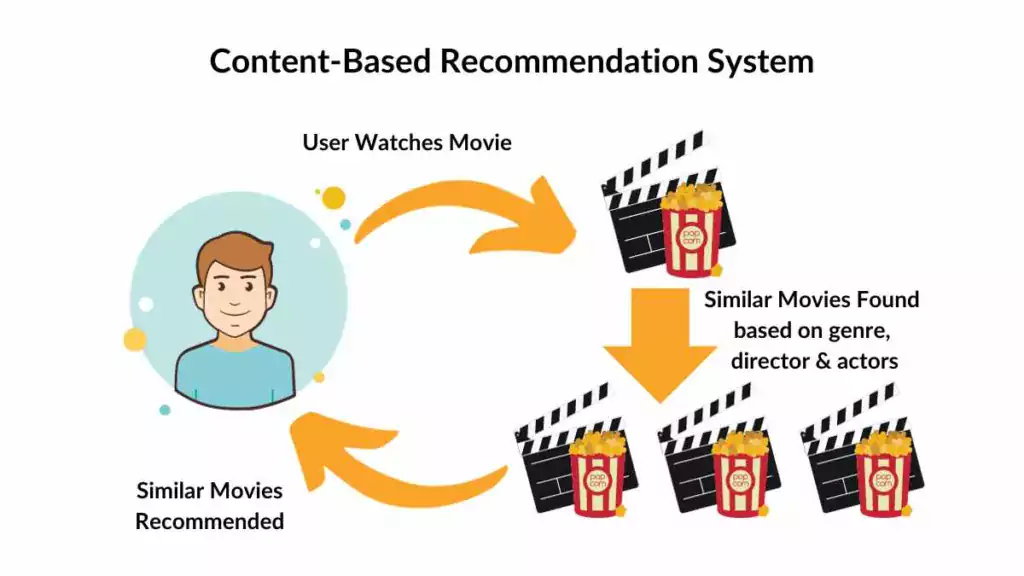

<font color = 'red'><b>Introduction</b></font>

This recommendation system acts as the same way as recommending the animes of the same genre which we like and have watched earlier , like if someone likes bleach he will be recommended animes like naruto and jujutsu kaisen . Here , we create a better way of recommendation by introducing other features of the content into our algorithm engine . Its a further improved system compared to the popularity based recommendation system we mentioned before this . 

<font color = 'red'><b>Disadvantages(Drawbacks)</b></font>

The main drawback of this algorithm is that it is limited to recommending the animes of the same genre . Nowadays the viewers want variety also . 

It will not recommend the animes which the viewer has not seen or liked in the past . 

<font color = 'red'><b>Use case </b></font>

Good if someone wants to watch the animes which are of the same type they watch recently . It helps them to re-feel those feelings they get from watching the previous anime  . 

<font color = 'red'><b>Refrence</b></font>

[Content based recommender system](https://towardsdatascience.com/content-based-recommender-systems-28a1dbd858f5)



In [292]:
def find_top_k_similiar(anime_id ,top_k , dataset , mapping ):
  anime_row = dataset[anime_id, :]
  sorted_indices = sorted(range(len(anime_row)), key=lambda i: anime_row[i])
  top_k_anime = sorted_indices[:top_k]

  top_k_anime = [mapping[i] for i in top_k_anime]
  return top_k_anime 

rated_anime = dataset[dataset['anime_id'].isin(Ratings_Dataset['anime_id'])].copy()

# Split the genres into separate columns
genre = rated_anime['genre'].str.split(",", expand=True)
# get all possible genre
all_genre = set()
[all_genre.update(genre[c].str.lower().str.strip().unique()) for c in genre.columns]


all_genre.discard(None)

# Calculate the number of possible genres
num_possible_genres = len(all_genre)
print(f"The number of possible genres is: {num_possible_genres}")

# Create item-genre matrix
item_genre_mat = rated_anime[['name', 'genre']].copy()
item_genre_mat['genre'] = item_genre_mat['genre'].str.lower().str.strip()

# Create binary columns for each genre
for genre in tqdm(all_genre):
    item_genre_mat[genre] = item_genre_mat['genre'].str.contains(genre).astype(int)

item_genre_mat.drop(['genre'], axis=1, inplace=True)
item_genre_mat.set_index('name', inplace=True)

# Calculate cosine similarity matrix

index1 = {ind:name for ind,name in enumerate(item_genre_mat.index)}
main_arr = {v:k for k,v in index1.items()}


cosine_mat = cosine_similarity(item_genre_mat)

# Function to find top k similar items
def find_top_k_similar(item_index, top_k, dataset, mapping):
    similarities = dataset[item_index]
    similar_indices = similarities.argsort()[::-1][1:top_k + 1]  # Exclude self
    similar_items = [mapping[ind] for ind in similar_indices]
    return similar_items

# Find similar shows for 'Naruto' and 'Death Note'
similar_anime_naruto = find_top_k_similar(main_arr['Naruto'], top_k=10, dataset=cosine_mat, mapping=index1)
similar_anime_death_note = find_top_k_similar(main_arr['Death Note'], top_k=10, dataset=cosine_mat, mapping=index1)

# Show recommended shows for 'Naruto' and 'Death Note'
recommended_naruto = dataset.loc[dataset['name'].isin(similar_anime_naruto), ['name', 'genre']]
recommended_death_note = dataset.loc[dataset['name'].isin(similar_anime_death_note), ['name', 'genre']]

print("\nRecommended shows for Naruto:")
print(recommended_naruto)

print("\nRecommended shows for Death Note:")
print(recommended_death_note)

# Clean up memory
del cosine_mat
gc.collect()

The number of possible genres is: 43


  0%|          | 0/43 [00:00<?, ?it/s]


Recommended shows for Naruto:
                                                   name  \
175                              Katekyo Hitman Reborn!   
486                            Boruto: Naruto the Movie   
841                                              Naruto   
1103  Boruto: Naruto the Movie - Naruto ga Hokage ni...   
1472        Naruto: Shippuuden Movie 4 - The Lost Tower   
1573  Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...   
2458               Naruto Shippuuden: Sunny Side Battle   
2997  Naruto Soyokazeden Movie: Naruto to Mashin to ...   
7628                            Kyutai Panic Adventure!   
7837                      Battle Spirits: Ryuuko no Ken   

                                                  genre  
175                Action, Comedy, Shounen, Super Power  
486   Action, Comedy, Martial Arts, Shounen, Super P...  
841   Action, Comedy, Martial Arts, Shounen, Super P...  
1103  Action, Comedy, Martial Arts, Shounen, Super P...  
1472  Action, Comedy, Martial

42

3.Collaborative filtering

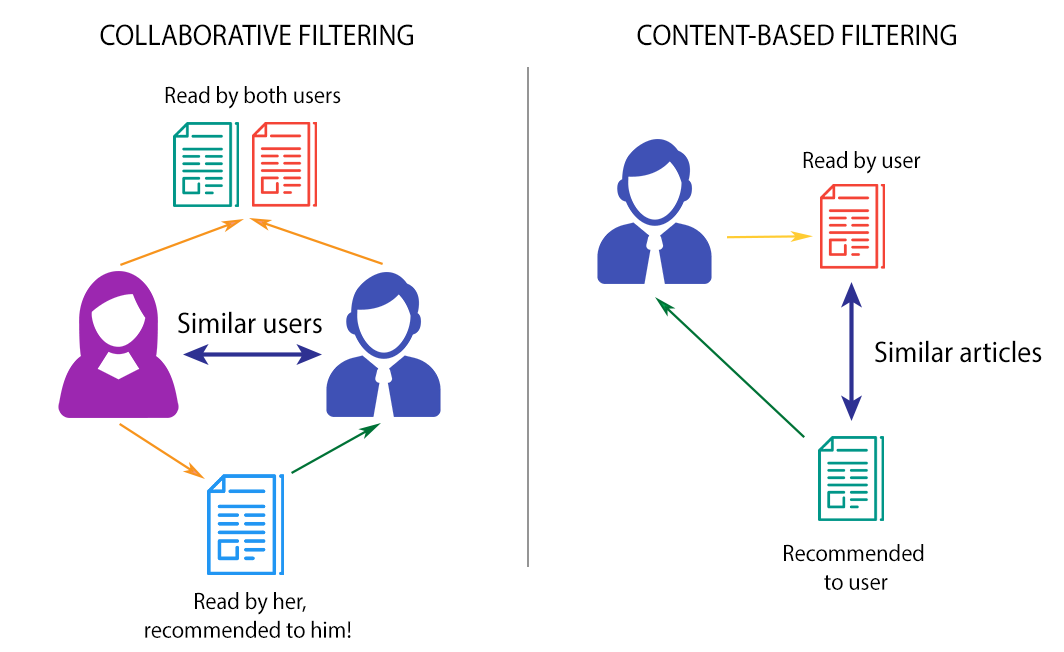
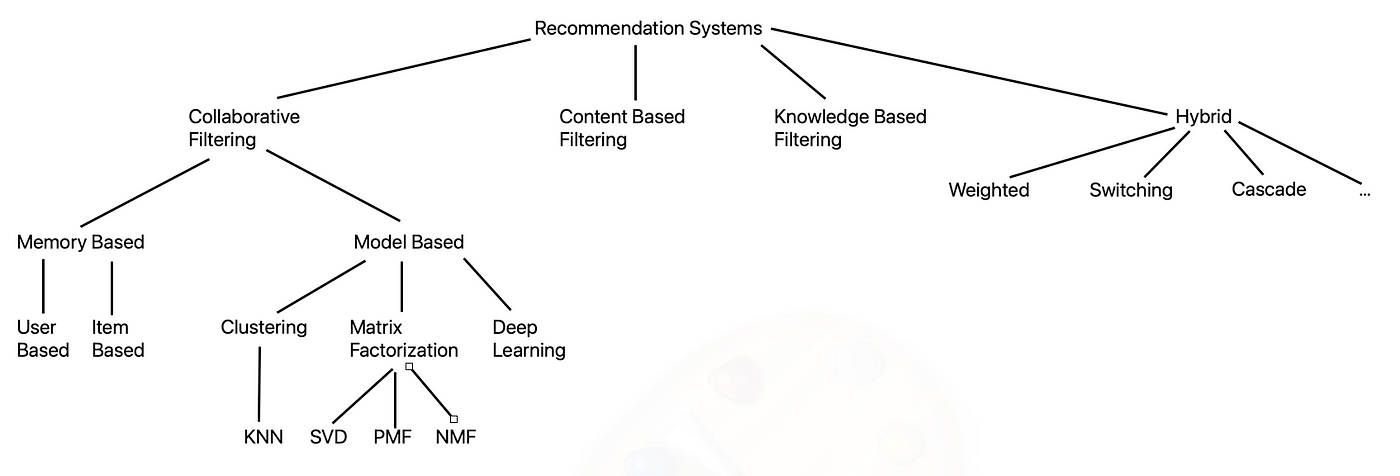
<font color = 'red'><b>Introduction</b></font>

The collabrative filtering algorithm uses "User behaviour" for recommending systems . This is widely used in the industry nowadays as it is not dependent on additional information . There are different types of collaborative filtering techniques . Some of the memory based collaborative filtering are as follows:

a)User based - The user-similarity matrix will consist of some distance metric that measures the similarity between any two pairs of users . This is useful when the number of users is less. Its not much effective when there are a lot of users as it takes a lot of time to compute the similarity between all the users . This leads to product-product collaborative filtering , which is effective when the number of users is more than the number of products , in this case the number of users should be more than the number of recommended animes . 

b)Product based - Similarly, the item-similarity matrix assesses the resemblance between any two sets of items.

<font color = 'red'><b>Disadvantages(Drawbacks)</b></font>

Some of the disadvantages are also written in the user based collabrative filtering column . 

When a new user or item is introduced to the dataset, it triggers what's known as a Cold Start situation. This can manifest in two ways:

1)New User (Visitor): Since this user lacks any historical data, our system lacks insights into their preferences. One approach to address this is by leveraging recent overall or regional trends to gauge popular choices.

2)New Item (Product): The more interactions a product garners, the more effective our model becomes in recommending it accurately to the appropriate users. Content-based filtering is a technique that can be employed to mitigate this challenge

<font color = 'red'><b>Use case </b></font>

Collaborative filtering is a technique used in recommendation systems to make predictions about an individual's preferences based on the preferences of similar users . 

<font color = 'red'><b>Refrence</b></font>

https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/
https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/



In [285]:
# lets change the rating with -1 value with 0 (this is a way to check the animes which the users did not like )
def replace_rating(Ratings_Dataset ,dataset):
  replaced = Ratings_Dataset[Ratings_Dataset['anime_id'].isin(dataset['anime_id'])].copy()

  replaced['rating'].replace(-1 , 0 , inplace = True) 
  unique_users = replaced['user_id'].nunique()
  unique_animes = replaced['anime_id'].nunique() 

  print(f"Unique users: {unique_users:,}\nUnique anime: {unique_animes:,}")

  return unique_users , unique_animes , replaced


unique_users, unique_animes , replaced = replace_rating(Ratings_Dataset , dataset)

unique_users_ids = sorted(replaced['user_id'].unique())
unique_anime_ids = sorted(replaced['anime_id'].unique())

user_map = {user_id: i for i,user_id in zip(range(len(unique_users_ids)) , unique_users_ids)}
anime_map = {anime_id: i for i,anime_id in zip(range(len(unique_anime_ids)) , unique_anime_ids)}

replaced['user_id_collab'] = replaced['user_id'].map(user_map)
replaced['anime_id_collab'] = replaced['anime_id'].map(anime_map)

replaced = replaced.merge(dataset[['anime_id' , 'name']] , on='anime_id' , how = 'left')

final_map_id_to_name = {i:name for i, name in zip(replaced['anime_id_collab'] , replaced['name'])}
final_map_name_to_id = {name:i for i, name in final_map_id_to_name.items()}

# print(final_map_name_to_id)

row = replaced['user_id_collab'];column = replaced['anime_id_collab'];data = replaced['rating']
matrix = csr_matrix((data , (row , column)) , shape=(unique_users , unique_animes ))
matrix.eliminate_zeros  ; 
sparcity  = float(len(matrix.nonzero()[0]) ) ; sparcity /= (matrix.shape[0] * matrix.shape[1]) ; sparcity *= 100 ; 

print(f"Sparcity: {sparcity:4.2f} . This tell us that {sparcity:4.2f} of the user-product ratings have a value . ") # calculated according to mentioned in the refrences  


# now lets construct the train and the test set . 
def create_database(matrix , test_size = 0.2):
  train = matrix.copy() 
  row_test = [] ; column_test = [] ; data_test = [] ; 
  for user in tqdm(range(matrix.shape[0])):
    rating_by_user = matrix[user , :].nonzero()[1]
    ratings_test = np.random.choice(rating_by_user , size=int(test_size * len(rating_by_user)) , replace=False) 
    row_test.extend([user]*len(ratings_test))
    column_test.extend(list(train[user , ratings_test].toarray()[0])) 
    data_test.extend(list(train[user, ratings_test].toarray()[0]))
    train[user , ratings_test] = 0  

  test = csr_matrix((data_test , (row_test , column_test)) , shape=(matrix.shape[0] , matrix.shape[1]))

  test.eliminate_zeros()  
  return train , test 


train, test = create_database(matrix)

Unique users: 73,515
Unique anime: 11,162
Sparcity: 0.77 . This tell us that 0.77 of the user-product ratings have a value . 


  0%|          | 0/73515 [00:00<?, ?it/s]

Now , we have our database ,  we can now do couple of methods on this train and test . They are as follows :

3) SUB-SECTION-1

<font color = 'red'><b>Memory based approache</b></font>

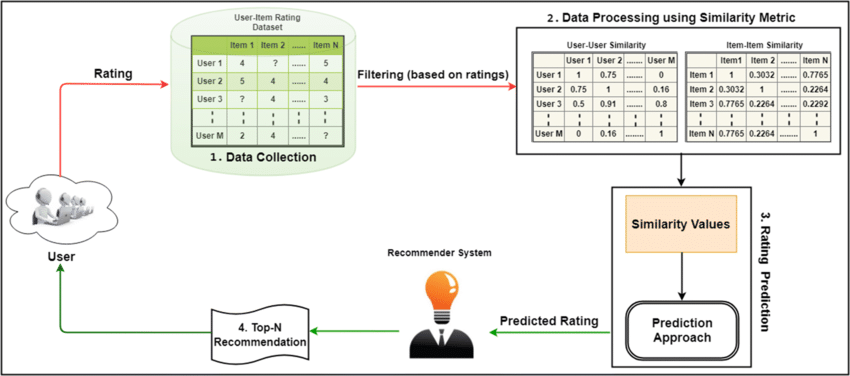

<font color = 'red'><b>Introduction</b></font>


The fundamental distinction between memory-based approaches and model-based techniques lies in their parameter learning process. Memory-based methods do not involve learning parameters through algorithms like gradient descent; instead, they rely solely on arithmetic operations such as Cosine similarity or Pearson correlation coefficients to compute the proximity between users or items. These methods leverage historical user rating data to gauge similarity between users or items, aiming to recommend unseen items by identifying the most similar ones. This process forms the basis of memory-based collaborative filtering recommender systems.

<font color = 'red'><b>How to proceed(implementation)</b></font>

The size of user-product matrix is really huge . It's computably impossible to compute the user_features with unique_users X unique_animes shape or the anime features for the same reason . 

Thus ,  we drop some of the rows for demonstrating this method .  

Also, we can create matrix of lower dimension using "TruncatedSVD" or "PCA" .

<font color = 'blue'><b>User-based</b></font>

we find the similiar users based on different strategies like person correlation , cosine similarity or KNN nearest neighbour  . we average the rating of each item based on the group of similiar users . Rank the items based on the average rating descendently and recommend the target user with the anime that they never rated it before ranking from the highest top k  average rating .



<font color = 'blue'><b>Product-based</b></font>

We identify clusters of comparable products using Pearson correlation, cosine similarity, or KNN (k-nearest neighbors) algorithms. Then, we select the top k most similar items for recommendations. It's important to clarify that item similarity in this context is not based on content (unlike content-based recommendations) but rather on the explicit ratings derived from user behavior as captured in the user-product matrix.


<font color = 'red'><b>Disadvantages(Drawbacks)</b></font>

1)It's not scalable due to the sprasity of the data. 
 
2)Constructing the similarity matrix for every new user introduction is challenging to maintain and operationalize.

<font color = 'red'><b>Use case </b></font>

The list result can be changed into a front - end website which we are not doing in the project as of now due to lack of time . (it can be a good summer project)
 . 

It can be showcased like "because you like deathnote , here are some suggestions : "
 
<font color = 'red'><b>Refrence</b></font>

https://towardsdatascience.com/how-does-collaborative-filtering-work-da56ea94e331

https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0



In [290]:
# first compute the similarity with the whole matrix , (75k X 11 k) , we cant store the entire matrix, for now we will undersample the data set (by 90%)

def create_undersample(matrix , val = 0.1):
  index_points = np.random.choice(matrix.shape[0] , size=int(val * matrix.shape[0]) , replace=False)

  return train[index_points, :] 

epsilon = 1e-9 ; train_reduced = create_undersample(train).toarray() + epsilon ; correlation_matrix_product = np.corrcoef(train_reduced.T) ; 
similar_anime_naruto = find_top_k_similar(final_map_name_to_id['Naruto'], top_k=10, dataset=correlation_matrix_product, mapping=final_map_id_to_name)
naruto_table = dataset.loc[dataset['name'].isin(similar_anime_naruto), ['name', 'genre']]
print("\nRecommended Animes for Naruto:")
print(tabulate(naruto_table, headers='keys', tablefmt='fancy_grid', showindex=False))

similar_anime_death_note = find_top_k_similar(final_map_name_to_id['Death Note'], top_k=10, dataset=correlation_matrix_product, mapping=final_map_id_to_name)
death_note_table = dataset.loc[dataset['name'].isin(similar_anime_death_note), ['name', 'genre']]
print("\nRecommended Animes for Death Note:")
print(tabulate(death_note_table, headers='keys', tablefmt='fancy_grid', showindex=False))

del  train_reduced, correlation_matrix_product
gc.collect()  
  

# this is now done for memory-based approach


Recommended Animes for Naruto:
╒═════════════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════╕
│ name                                                                    │ genre                                                                  │
╞═════════════════════════════════════════════════════════════════════════╪════════════════════════════════════════════════════════════════════════╡
│ Death Note                                                              │ Mystery, Police, Psychological, Supernatural, Thriller                 │
├─────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────┤
│ Dragon Ball Z                                                           │ Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power │
├─────────────────────────────────────────────────────────────────────────

0

3) SUB-SECTION-2

<font color = 'red'><b>Model-based approach</b></font>

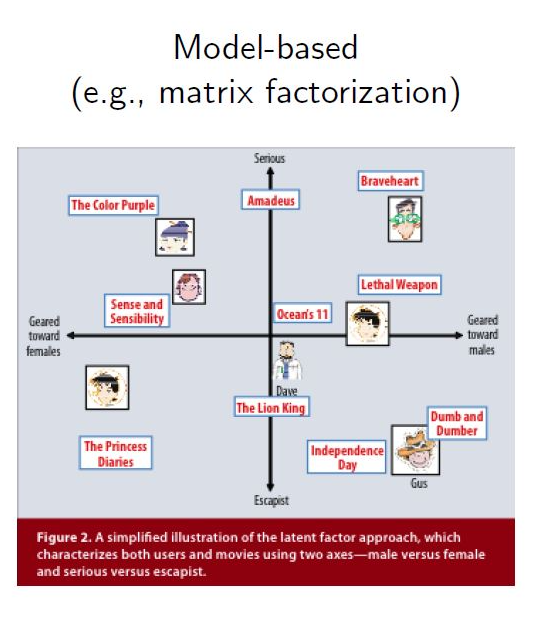

<font color = 'red'><b>Introduction</b></font>

Model-based collaborative filtering employs machine learning techniques to forecast users’ ratings for items they haven’t rated. Various algorithms fall under model-based CF, with matrix factorization models like SVD being particularly prevalent. Other approaches include applying latent Dirichlet allocation or utilizing Markov decision processes.


<font color = 'red'><b>How to proceed(implementation)</b></font>

The size of user-product matrix is really huge . It's computably impossible to compute the user_features with unique_users X unique_animes shape or the anime features for the same reason . 

Thus ,  we drop some of the rows for demonstrating this method .  

Also, we can create matrix of lower dimension using "TruncatedSVD" or "PCA" .

<font color = 'blue'><b>User-based</b></font>


We extract user_features and anime_features using matrix factorization techniques to capture the latent factors within the user-item interaction matrix. This helps uncover hidden patterns in user preferences.

Next, we identify clusters of similar users based on Pearson correlation, cosine similarity, or KNN (k-nearest neighbors). These clusters can vary in size and are determined based on similarity metrics.

We then calculate the average rating for each item within the group of similar users. Items are ranked in descending order based on their average ratings. For a target user, we recommend movies they haven't rated before, starting with the highest-ranked items in the top-k list of average ratings.



<font color = 'blue'><b>Product-based</b></font>

We leverage matrix factorization techniques to derive user_features and anime_features, aiming to capture the latent structure within the user-item interaction matrix.

Subsequently, we focus on anime_features as an example. Using methods like Pearson correlation, cosine similarity, or KNN (k-nearest neighbors), we compute similarities between each item. This analysis helps identify the top_k most similar items for recommendation.

It's important to note that this similarity isn't based on content (as in content-based recommendation) or explicit user behavior (as in memory-based CF). Instead, it's rooted in the latent factors uncovered through matrix decomposition, representing underlying factors that aren't explicitly interpretable.



<font color = 'red'><b>Disadvantages(Drawbacks)</b></font>

1)It's not scalable due to the sprasity of the data. 
 
2)Constructing the similarity matrix for every new user introduction is challenging to maintain and operationalize.

<font color = 'red'><b>Use case </b></font>

The list result can be changed into a front - end website which we are not doing in the project as of now due to lack of time . (it can be a good summer project)
 . 

It can be showcased like "because you like deathnote , here are some suggestions : "
 
<font color = 'red'><b>Refrences</b></font>

https://towardsdatascience.com/how-does-collaborative-filtering-work-da56ea94e331

https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)



Lets us use the method of Matrix factorization - TruncatedSVD(sklearn)
 
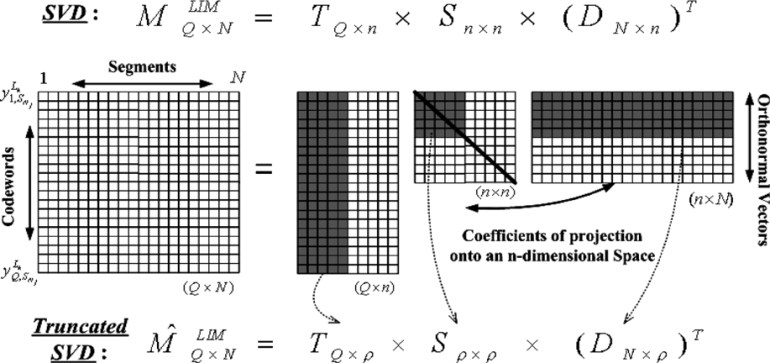

Truncated Singular Value Decomposition (SVD) and Principal Component Analysis (PCA) share similarities in that they both involve dimensionality reduction techniques. However, they operate differently in terms of the input data they work with.

Truncated SVD is derived directly from the data matrix, aiming to factorize it into singular vectors and values. Unlike regular SVD, truncated SVD allows for a specified number of columns, enabling a controlled truncation of the factorization.

On the other hand, PCA performs its factorization based on the covariance matrix of the data. It seeks to find the principal components that capture the maximum variance in the data, thus aiding in dimensionality reduction and feature extraction.

In essence, while both techniques aim to reduce dimensionality and uncover underlying patterns in data, they do so through different mathematical approaches and with distinct input considerations.


In [289]:
epsilon = 1e-9 ; latent_factors = 10 ; 
anime_reduced_svd = TruncatedSVD(n_components=latent_factors)  ; anime_features = anime_reduced_svd.fit_transform(train.T) + epsilon
user_reduced_svd = TruncatedSVD(n_components=latent_factors) ; user_features = user_reduced_svd.fit_transform(train) + epsilon ;  
print(anime_features.shape)
print(user_features.shape)


# lets first do item based collaborative filtering 
#calcualte the correlation matrix first 
correlation_matrix  = np.corrcoef(anime_features)  ;
similar_anime_naruto = find_top_k_similar(final_map_name_to_id['Naruto'], 10, correlation_matrix, final_map_id_to_name)
naruto_table_corr = dataset.loc[dataset['name'].isin(similar_anime_naruto), ['name', 'genre']]
print("\nSimilar Animes for Naruto (Pearson Correlation):")
print(tabulate(naruto_table_corr, headers='keys', tablefmt='fancy_grid', showindex=False))

similar_anime_death_note = find_top_k_similar(final_map_name_to_id['Death Note'], 10, correlation_matrix, final_map_id_to_name)
death_note_table_corr = dataset.loc[dataset['name'].isin(similar_anime_death_note), ['name', 'genre']]
print("\nSimilar Animes for Death Note (Pearson Correlation):")
print(tabulate(death_note_table_corr, headers='keys', tablefmt='fancy_grid', showindex=False))


(11162, 10)
(73515, 10)

Similar Animes for Naruto (Pearson Correlation):
╒═════════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════╕
│ name                                        │ genre                                                                  │
╞═════════════════════════════════════════════╪════════════════════════════════════════════════════════════════════════╡
│ Katekyo Hitman Reborn!                      │ Action, Comedy, Shounen, Super Power                                   │
├─────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────┤
│ Saint Seiya: The Lost Canvas - Meiou Shinwa │ Action, Adventure, Martial Arts, Shounen, Super Power, Supernatural    │
├─────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────┤
│ Fairy Tail                                  │ Action, Adventure, Comedy, Fant

In [288]:
#above was based on Pearson correlation (now lets make on cosine similarity)
cosine_matrix = cosine_similarity(anime_features) ; 

similar_anime_naruto = find_top_k_similar(final_map_name_to_id['Naruto'], 10, cosine_matrix, final_map_id_to_name)
naruto_table = dataset.loc[dataset['name'].isin(similar_anime_naruto), ['name', 'genre']]
print("\nSimilar Animes for Naruto:")
print(tabulate(naruto_table, headers='keys', tablefmt='fancy_grid', showindex=False))

similar_anime_death_note = find_top_k_similar(final_map_name_to_id['Death Note'], 10, cosine_matrix, final_map_id_to_name)
death_note_table = dataset.loc[dataset['name'].isin(similar_anime_death_note), ['name', 'genre']]
print("\nSimilar Animes for Death Note:")
print(tabulate(death_note_table, headers='keys', tablefmt='fancy_grid', showindex=False))


Similar Animes for Naruto:
╒══════════════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════╕
│ name                             │ genre                                                                             │
╞══════════════════════════════════╪═══════════════════════════════════════════════════════════════════════════════════╡
│ Fullmetal Alchemist: Brotherhood │ Action, Adventure, Drama, Fantasy, Magic, Military, Shounen                       │
├──────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────┤
│ Death Note                       │ Mystery, Police, Psychological, Supernatural, Thriller                            │
├──────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────┤
│ Fullmetal Alchemist              │ Action, Adventure, Comedy, Drama, Fantasy, Magic, Military, Shounen               │
├───

<font color = 'red'><b>SUMMARY</b></font>

This method demonstrates how we can calculate similarity using a specified number of latent factors.

Recommendations are then made based on these latent factors, which aren't directly interpretable but are mathematically the ones that minimize the loss between actual ratings and reconstructed ratings.

Although this approach reduces the size of the matrix compared to memory-based methods, it still has limitations. As the number of users or items grows over time, computational resources become strained, potentially reaching their limits. This scalability issue highlights the need for more efficient techniques in large-scale recommender systems.